In [1]:
import sys
import statistics

from qetu_sim import *

import numpy as np
import scipy.linalg
import itertools
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.transpiler import Layout
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import Permutation
from qiskit.visualization import *
from qiskit_aer import AerSimulator

In [2]:
u = 1
t = 1
delta_t = 1
n = 1
num_sites = 4

In [3]:
H_ref = ref_fh_hamiltonian(u=u, t=t, WMI_qubit_layout=True, include_aux=True)
λ, v = np.linalg.eigh(H_ref)
ground_state_energy = λ[0]
ground_state_vector = v[:,0]

In [4]:
print(ground_state_energy)

-5.723265519527199


In [5]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
pauli_error, depolarizing_error, thermal_relaxation_error)
error_1q = 1e-3
error_2q = 1e-2
error_readout = 1e-1

# QuantumError objects
depol_error_1 = depolarizing_error(error_1q, 1)
depol_error_2 = depolarizing_error(error_2q, 2)

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depol_error_1, ["sx", "sy", "x", "y", "u3"])
noise_model.add_all_qubit_quantum_error(depol_error_2, ["cp", "pswap"])

noise_model.add_basis_gates(['unitary'])

In [6]:
#noise_model = define_noise_model(t1=200e3, t2=300e3, duration_1q=20, duration_2q=60, duration_readout=1500, fidelity_1q=0.99999, fidelity_2q=0.99995, fidelity_readout=0.9998)

degree_list = range(48,51,1)
trotter_steps_list = range(1,2)
energy_estimation_list = []
overlap_list = []
statevector_list = []

for degree in degree_list:
    E_min, E_mu_m, E_mu_p, E_max = calculate_qsp_params(u, t)
    qsp = QSPPhase()
    phi_seq_su2 = qsp.cvx_qsp_heaviside(
        degree,
        E_min,
        E_mu_m, 
        E_mu_p, 
        E_max
    )
    #phi_vec = convert_Zrot_to_Xrot(phi_seq_su2)
    phi_vec = phi_seq_su2
    for trotter_steps in trotter_steps_list:
        print("Degree: " + str(degree) + "\t Trotter steps: " + str(trotter_steps))
        # Construct quantum circuit
        QETU_circ = construct_QETU_circ(u, t, trotter_steps, phi_vec)
        QETU_circ_WMI = transpile_QETU_to_WMI(QETU_circ)
        QETU_circ_WMI = add_pswap_labels(QETU_circ_WMI)
        QETU_circ_WMI = add_sy_labels(QETU_circ_WMI)
        onsite_circ_WMI, hop_1_circ_WMI, hop_2_circ_WMI = create_energy_estimation_circuits(QETU_circ_WMI)
        hop_2_circ_WMI = add_pswap_labels(hop_2_circ_WMI)
        hop_2_circ_WMI = add_sy_labels(hop_2_circ_WMI)        
        # estimate ground state
        energy_shots = []
        E0_meas = estimate_ground_state_energy_from_circ(onsite_circ_WMI, hop_1_circ_WMI, hop_2_circ_WMI, u=1, t=1, num_shots=1_000_000, noise_model=None, use_num_conservation=True)
        energy_shots.append(E0_meas)
        energy_estimation_list.append(energy_shots)
        print("E0_meas: " + str(E0_meas))
        print("|E0 - E0_meas|: " + str(abs(ground_state_energy - E0_meas)))
        print("depth: " + str(hop_1_circ_WMI.depth()))     


starting matlab engine..
Degree: 48	 Trotter steps: 1
E0_meas: -5.711550287303451
|E0 - E0_meas|: 0.011715232223747485
depth: 2408

starting matlab engine..

stopping matlab engine..
Degree: 49	 Trotter steps: 1
E0_meas: -5.722053603474584
|E0 - E0_meas|: 0.0012119160526147255
depth: 2458

starting matlab engine..

stopping matlab engine..
Degree: 50	 Trotter steps: 1
E0_meas: -5.720147449825308
|E0 - E0_meas|: 0.0031180697018902137
depth: 2508


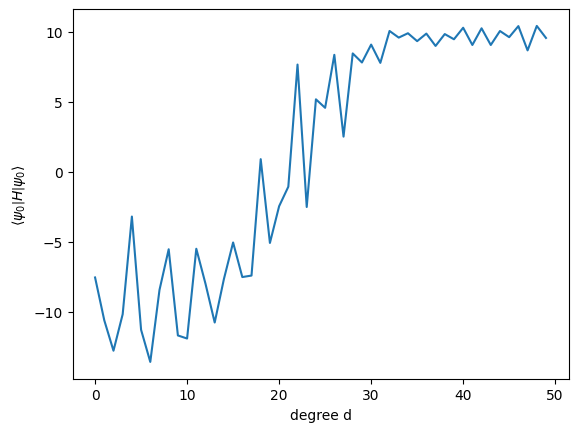

In [ ]:
plt.xlabel("degree d")
plt.ylabel("$ \left \langle \psi_0 \middle| H \middle| \psi_0 \\right \\rangle $")
plt.plot(energy_estimation_list)

In [ ]:
print(ground_state_energy)

-5.723265519527199


In [ ]:
for i in range(len(energy_estimation_list)):
    print("(" + str(i+1) + ", " + str(energy_estimation_list[i][0]) + ")")

(1, -12.931278196118505)
(2, -16.326624022547595)
(3, -14.448164721735552)
(4, -12.155552799084896)
(5, -15.143184653557606)
(6, -17.326804700243912)
(7, -15.40109794283216)
(8, -13.75919425583566)
(9, -16.26739113034881)
(10, -19.952420465921804)
(11, -19.712313290708618)
(12, -18.866621114303072)
(13, -20.031018048336403)
(14, -20.926740142570484)
(15, -20.310219127053877)
(16, -19.901283041815248)
(17, -20.94606615056521)
(18, -22.10636471133136)
(19, -22.146204097969623)
(20, -21.985226608678882)
(21, -22.178057282861374)
(22, -22.344789725251623)
(23, -22.245868325550404)
(24, -22.247903831021056)
(25, -22.313528034573412)
(26, -22.63070799488482)
(27, -22.540193912293766)
(28, -22.59343487338054)
(29, -22.592012262882005)
(30, -22.494971886452547)
(31, -22.568616923404758)
(32, -22.5899985454019)
(33, -22.61164783666323)
(34, -22.615619451299388)
(35, -22.66334337418956)
(36, -22.586092467019633)
(37, -22.605879796824055)
(38, -22.615461048972136)
(39, -22.63751381528567)
(40, -2